In [46]:
import pandas as pd
from google.cloud import bigquery
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#dividir train y test
from sklearn.model_selection import train_test_split,cross_val_predict, cross_val_score
#codificar columnas
from sklearn.preprocessing import LabelEncoder
#metricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif

#tiempo modelos
import time

#crear tablas
from tabulate import tabulate






## Importar tabla de los datos procesados

In [2]:
def importar_tabla_bigquery (id_proyecto, tabla, name_dataframe): 

    client = bigquery.Client(project=id_proyecto)

    #consulta a la tabla
    query = f"SELECT * FROM `{tabla}`"

    #ejecutar la consulta
    dataframe = client.query(query).to_dataframe()

    #cambiar nombre al dataframe 
    globals()[name_dataframe] = dataframe

In [3]:
#COMPLETAR CON LOS DATOS DE LA TABLA QUE SE QUIERE IMPORTAR 
id_proyecto="tfg-ayudasaludmental-12345"
tabla_importar= "DatosTech.datos_tech_procesados"
name_dataframe= "datos_tech_procesados"

importar_tabla_bigquery(id_proyecto,tabla_importar,name_dataframe)

## ORDENAR IMPORTANCIA COLUMNAS PARA MODELO

In [9]:
datos_tech_procesados.columns

Index(['fecha', 'edad', 'genero', 'pais', 'estado_res', 'autonomo',
       'antecedentes_familiares', 'tratamiento', 'interferencia',
       'num_empleados', 'trabajo_remoto', 'emp_tech', 'beneficios', 'opciones',
       'discusion_programa', 'recursos', 'anonimato', 'facilidad_licencia',
       'consecuencias_negativas_mental_emp',
       'consecuencias_negativas_fisica_emp', 'discusion_comp',
       'discusion_supervisor', 'mencion_entrevista_mental',
       'mencion_entrevista_fisica', 'prioridad_salud',
       'consecuencias_negativas_comp_trabajo', 'comentarios', 'id_user',
       'grupo_genero'],
      dtype='object')

In [4]:
#Elegir las columnas que se utilizaran y la columna que vamos a predecir
feature_columns = ["pais", "estado_res", "autonomo", "antecedentes_familiares", "interferencia",
                   "num_empleados", "trabajo_remoto", "emp_tech", "beneficios", "opciones",
                   "discusion_programa", "recursos", "anonimato", "facilidad_licencia",
                   "consecuencias_negativas_mental_emp", "consecuencias_negativas_fisica_emp",
                   "discusion_comp", "discusion_supervisor", "mencion_entrevista_mental",
                   "mencion_entrevista_fisica", "prioridad_salud", "consecuencias_negativas_comp_trabajo",
                   "grupo_genero"]


target_column = "tratamiento"

In [5]:
#filtrar solo las columnas necesarias en el dataframe y 
datos = datos_tech_procesados[feature_columns + [target_column]]

In [6]:
#codificar las varibles categoricas en numericas
label_encoder = LabelEncoder()
for column in feature_columns + [target_column]:
    if datos[column].dtype == "object":
        datos[column] = label_encoder.fit_transform(datos[column])

/Users/luciaprietogonzalez/Documents/Universidad/CURSO4/TFG/TFG DEFINITIVO/DESARROLLO/TFG/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [7]:
#calcular la importancia de las columnas
x = datos[feature_columns]
y = datos[target_column]
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(x, y)
scores = selector.scores_

In [8]:
#ordenar las columnas por importancia
importancia = [column for _, column in sorted(zip(scores, feature_columns), reverse=True)]
#imprimir las columnas por orden de importancia
print("Columnas ordenadas")
for column in importancia:
    print(column)

Columnas ordenadas
antecedentes_familiares
opciones
beneficios
grupo_genero
consecuencias_negativas_comp_trabajo
anonimato
interferencia
mencion_entrevista_mental
discusion_programa
recursos
pais
discusion_comp
estado_res
prioridad_salud
facilidad_licencia
mencion_entrevista_fisica
num_empleados
discusion_supervisor
emp_tech
trabajo_remoto
consecuencias_negativas_mental_emp
autonomo
consecuencias_negativas_fisica_emp


## CREACION DEL MODELO

Ya tengo las columnas seleccionadas y la columna a predecir, tambien estan codificadas "datos"

In [9]:
#dividir conjunto de datos en entrenamiento y prueba
X = datos[feature_columns]
y = datos[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
#definir modelos 
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    #se aumenta el numero maximo de iteraciones
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier()
}

Entrenar los modelos y evaluarlos

Metricas, curva roc, matriz de confusion, curvas de precision, y validacion cruzada

In [49]:
#entrenar cada modelo y evaluarlo
#lo guardamos 
resultados = []
curva_roc = {}
matriz_confusion = {}
curva_precision = {}
validacion_cruzada = {}
tiempos_entrenamiento = []


for model_name, model in models.items():
    
    #medir tiempo entrenamiento
    start_time = time.time()
    #entrenar modelo
    model.fit(X_train, y_train)
    #parar tiempo
    end_time = time.time()
    #calcular tiempo
    training_time = end_time - start_time
    
    y_pred = model.predict(X_test)

    #calcular metricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    resultados.append([model_name, accuracy, precision, recall, f1])

    #curva roc
    try:
        y_scores = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_scores = model.decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    curva_roc[model_name] = (fpr, tpr)

    #matriz confusion
    matriz_confusion[model_name] = confusion_matrix(y_test, y_pred)

    #curva de precision
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    curva_precision[model_name] = (precision, recall)

    #validacion cruzada
    cross_val_y_pred = cross_val_score(model, X, y, cv=5,scoring='accuracy')
    validacion_cruzada[model_name] = cross_val_y_pred

    #guardar tiempo de entrenamiento 
    tiempos_entrenamiento.append([model_name, training_time])
    

Mostrar cada uno de los modelos evaluados 

In [28]:
#mostrar en tabla metricas por modelo
resultados = pd.DataFrame(resultados, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print(resultados)

                 Model  Accuracy  Precision    Recall  F1 Score
0        Decision Tree  0.637450   0.661417  0.636364  0.648649
1        Random Forest  0.796813   0.809160  0.803030  0.806084
2  Logistic Regression  0.737052   0.766129  0.719697  0.742188
3                  SVM  0.669323   0.666667  0.742424  0.702509
4          Naive Bayes  0.729084   0.746154  0.734848  0.740458
5    Gradient Boosting  0.788845   0.768707  0.856061  0.810036


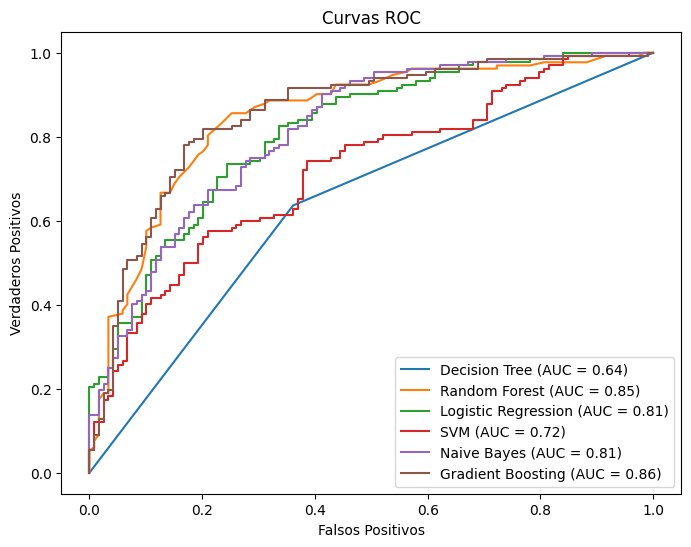

In [29]:
#mostrar curva ROC de cada modelo

plt.figure(figsize=(8, 6))
plt.title("Curvas ROC")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
for model_name, roc_curve_data in curva_roc.items():
    fpr, tpr = roc_curve_data
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
plt.legend()
plt.show()



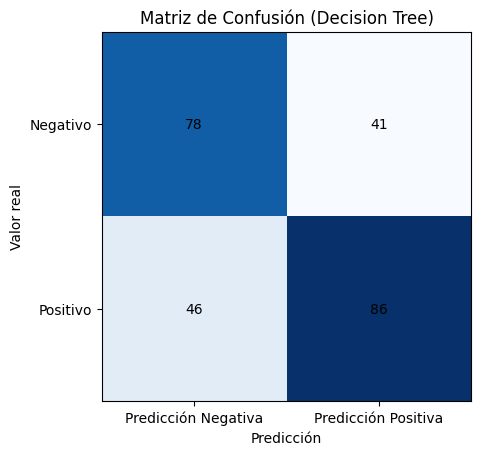

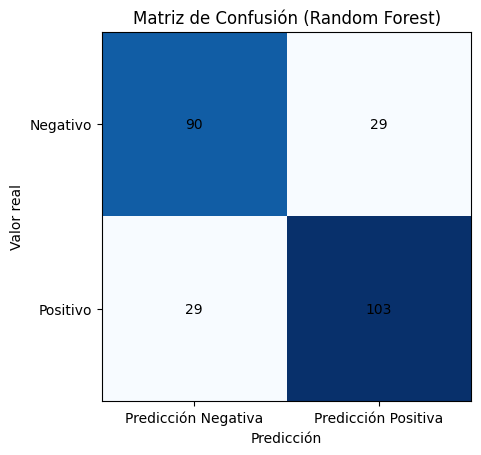

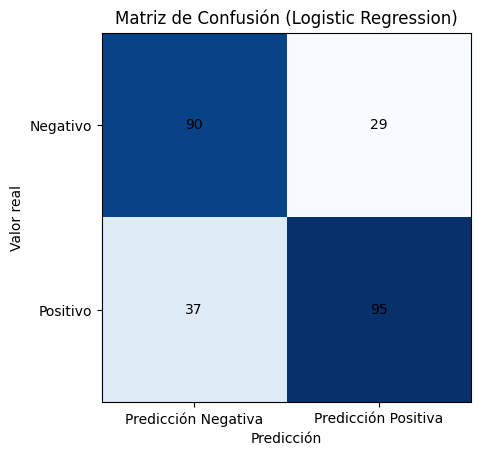

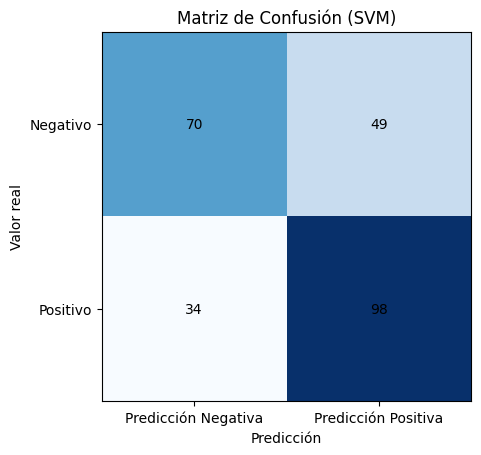

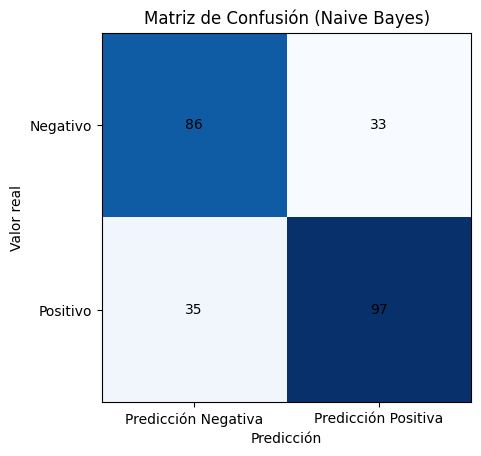

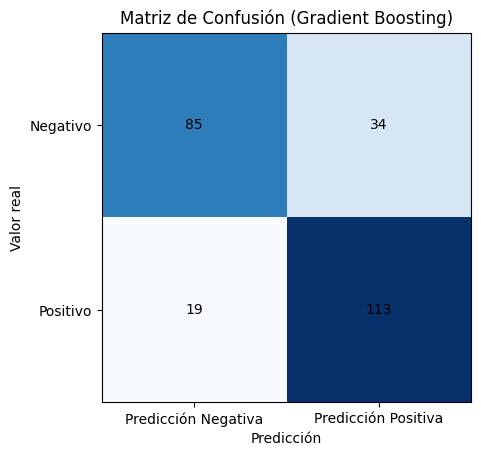

In [57]:
# Función para generar mapa de calor de una matriz de confusión
def plot_confusion(matriz, model_name):
    fig, ax = plt.subplots()
    im = ax.imshow(matriz, cmap='Blues')

    ax.set_xticks(np.arange(matriz.shape[1]))
    ax.set_yticks(np.arange(matriz.shape[0]))
    ax.set_xticklabels(["Predicción Negativa", "Predicción Positiva"])
    ax.set_yticklabels(["Negativo", "Positivo"])
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Valor real")
    ax.set_title(f"Matriz de Confusión ({model_name})")

    # Añadir los valores de la matriz en cada celda
    for i in range(matriz.shape[0]):
        for j in range(matriz.shape[1]):
            ax.text(j, i, str(matriz[i, j]), ha='center', va='center', color='black')

    #plt.colorbar(im)
    plt.show()

# Generar gráfico de barras y mapa de calor para cada modelo
for model_name, matriz in matriz_confusion.items():
    plot_confusion(matriz, model_name)

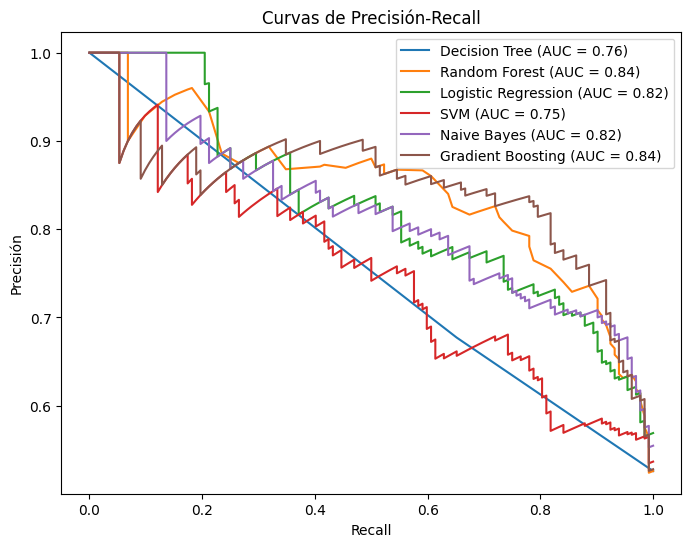

In [51]:
#curva precision vs recall de cada cada modelo
plt.figure(figsize=(8, 6))
plt.title('Curvas de Precisión-Recall')
plt.xlabel('Recall')
plt.ylabel('Precisión')
for model_name, pr_curve_data in curva_precision.items():
    precision, recall = pr_curve_data
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
plt.legend()
plt.show()

In [50]:
#mostrar resultados de la validacion cruzada
resultados_vc = pd.DataFrame(validacion_cruzada)
print(tabulate(resultados_vc, headers='keys', tablefmt='orgtbl'))


|    |   Decision Tree |   Random Forest |   Logistic Regression |      SVM |   Naive Bayes |   Gradient Boosting |
|----+-----------------+-----------------+-----------------------+----------+---------------+---------------------|
|  0 |        0.645418 |        0.729084 |              0.741036 | 0.585657 |      0.705179 |            0.721116 |
|  1 |        0.653386 |        0.733068 |              0.76494  | 0.613546 |      0.697211 |            0.737052 |
|  2 |        0.644    |        0.712    |              0.64     | 0.62     |      0.66     |            0.536    |
|  3 |        0.564    |        0.712    |              0.7      | 0.604    |      0.656    |            0.712    |
|  4 |        0.632    |        0.728    |              0.636    | 0.544    |      0.688    |            0.72     |


In [43]:
#mostrar  tiempos de entrenamiento de cada modelo
print(tabulate(tiempos_entrenamiento, headers=['Modelo', 'Tiempo de entrenamiento (segundos)'], tablefmt='orgtbl'))


| Modelo              |   Tiempo de entrenamiento (segundos) |
|---------------------+--------------------------------------|
| Decision Tree       |                           0.0110259  |
| Random Forest       |                           0.48933    |
| Logistic Regression |                           0.225212   |
| SVM                 |                           0.176456   |
| Naive Bayes         |                           0.00300026 |
| Gradient Boosting   |                           0.249918   |
